# FLIM Workflow Example

This notebook show an example of how one could automate the phasor plot generation and clustering in order to achieve a segmentation result based on lifetime differences.



In [14]:
from skimage import morphology
import napari
from napari.utils import nbscreenshot
import numpy as np
import napari_flim_phasor_plotter as flim_plot
import napari_clusters_plotter as ncp
from skimage.measure import label, regionprops_table
import hdbscan
from magicgui import magicgui
from typing import List, Tuple
import pandas as pd

Below are the parameters used in this workflow.

In [2]:
# phasor plot parameters
manual_threshold = 15
harmonic = 1
apply_median_filter = True
median_filter_iterations = 1

# hdbscan parameters
hdbscan_min_cluster_size = 40
hdbscan_min_samples = 40

## Open sample data in napari

In [3]:
viewer = napari.Viewer()

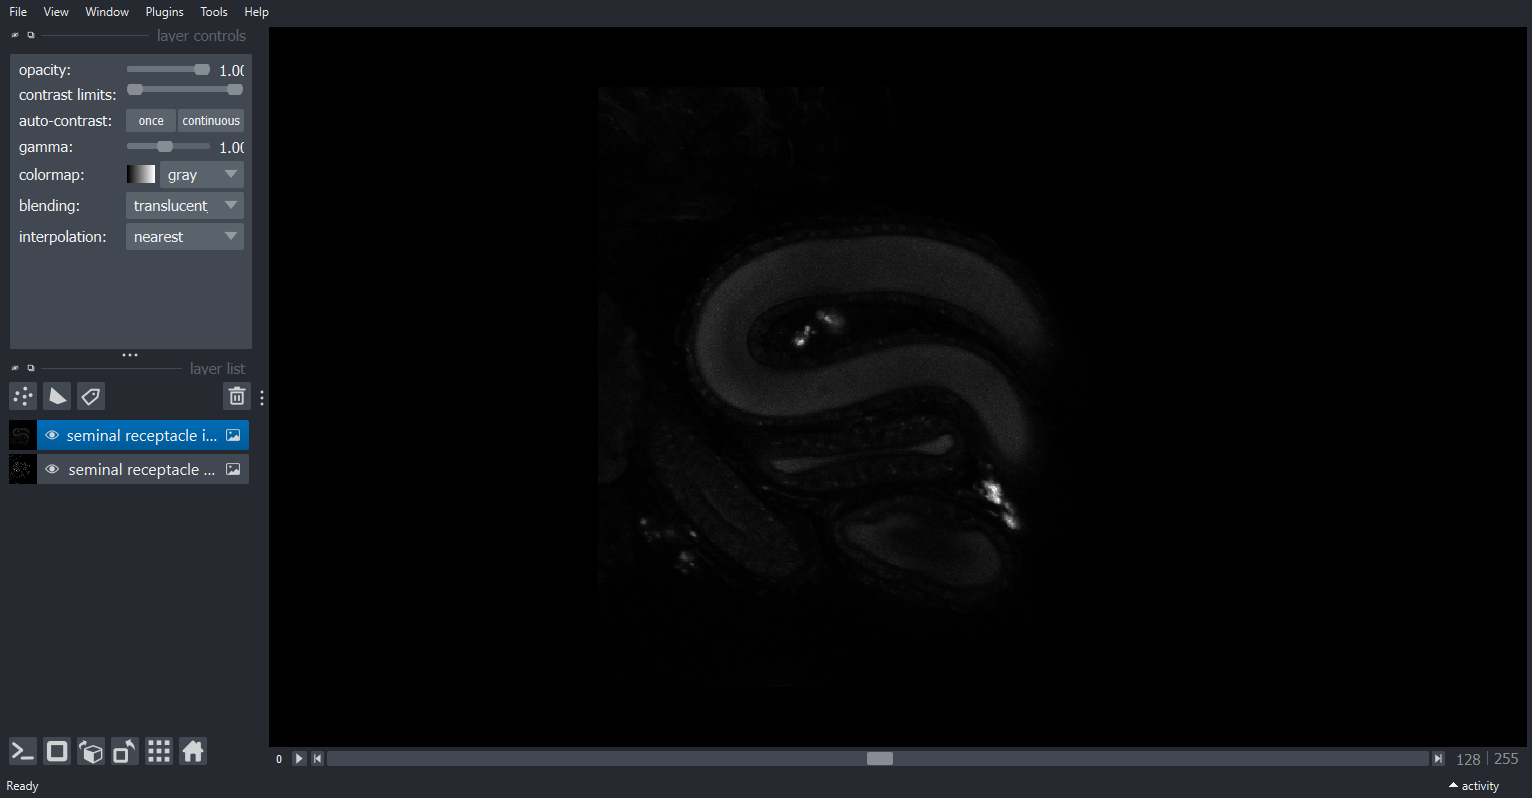

In [4]:
layer_raw_FLIM_image, layer_image = viewer.open_sample(plugin='napari-flim-phasor-plotter', sample='receptacle')
nbscreenshot(viewer)

## Make the phasor plot

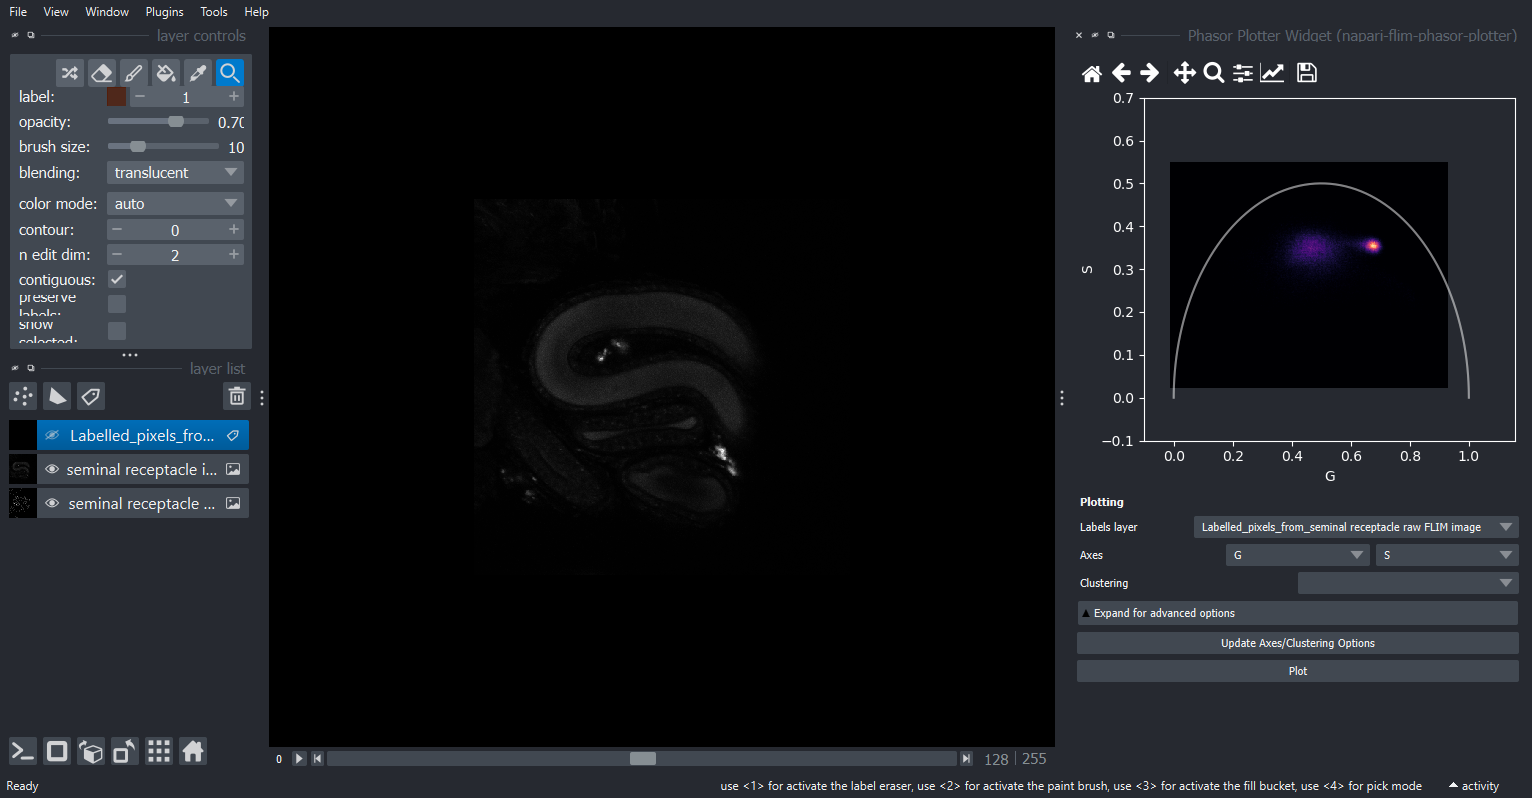

In [5]:
plot_maker_widget = flim_plot._widget.make_flim_phasor_plot()

phasor_plot_widget, labels_layer = plot_maker_widget(
        image_layer=layer_raw_FLIM_image,
        threshold = manual_threshold,
        apply_median = apply_median_filter,
        median_n = median_filter_iterations,
        napari_viewer = viewer)
nbscreenshot(viewer)

Set color scaling to logarithm

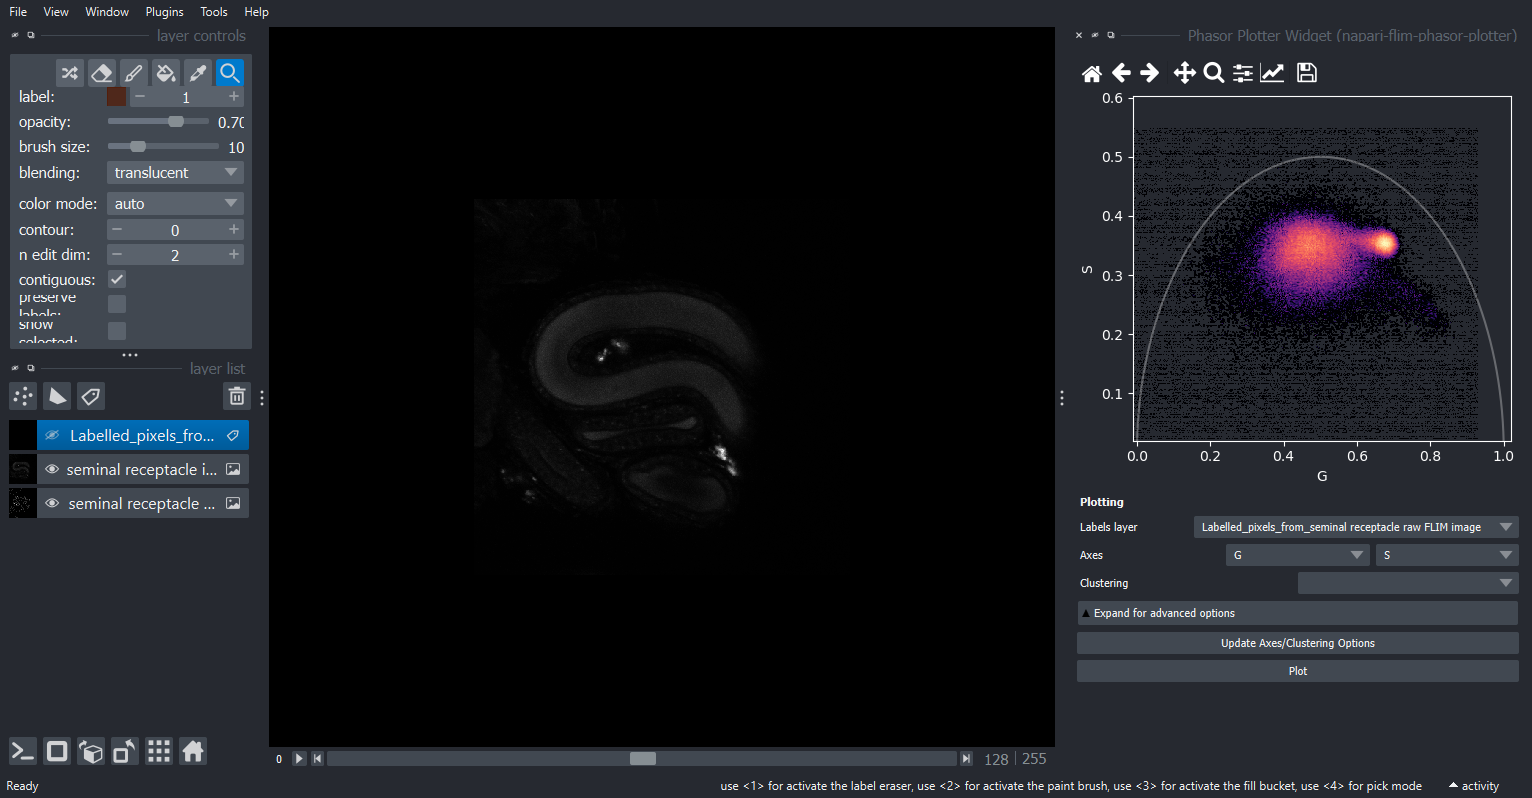

In [6]:
phasor_plot_widget.log_scale.setChecked(True)
nbscreenshot(viewer)

Get features table

In [7]:
features_table = labels_layer.features
features_table


label         G         S  frame
0            1  0.368575  0.378603      0
1            2  0.368575  0.379517      0
2            3  0.333649  0.379517      0
3            4  0.360470  0.362263      0
4            5  0.360470  0.362263      0
...        ...       ...       ...    ...
123724  123725  0.399062  0.289760      0
123725  123726  0.399062  0.286353      0
123726  123727  0.167012  0.289760      0
123727  123728  0.251258  0.329581      0
123728  123729  0.361668  0.355341      0

[123729 rows x 4 columns]

## Cluster 'G' and 'S' (with HDBSCAN)

In [8]:
clustering_hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=hdbscan_min_cluster_size,
    min_samples=hdbscan_min_samples,
)
hdbscan_predictions = clustering_hdbscan.fit_predict(features_table[['G', 'S']])
clustering_id = "HDBSCAN_CLUSTER_ID"

Add HDBSCAN predictions to table

In [9]:
features_table[clustering_id] = hdbscan_predictions
features_table

label         G         S  frame  HDBSCAN_CLUSTER_ID
0            1  0.368575  0.378603      0                  -1
1            2  0.368575  0.379517      0                  -1
2            3  0.333649  0.379517      0                  -1
3            4  0.360470  0.362263      0                  -1
4            5  0.360470  0.362263      0                  -1
...        ...       ...       ...    ...                 ...
123724  123725  0.399062  0.289760      0                  -1
123725  123726  0.399062  0.286353      0                  -1
123726  123727  0.167012  0.289760      0                  -1
123727  123728  0.251258  0.329581      0                  -1
123728  123729  0.361668  0.355341      0                  -1

[123729 rows x 5 columns]

Update layer features table and plotter options

In [10]:
labels_layer.features = features_table
# update clustering id list
phasor_plot_widget.update_axes_and_clustering_id_lists()
# set clustering id
phasor_plot_widget.plot_cluster_id.setCurrentText(clustering_id)

Display clusters on phasor plot

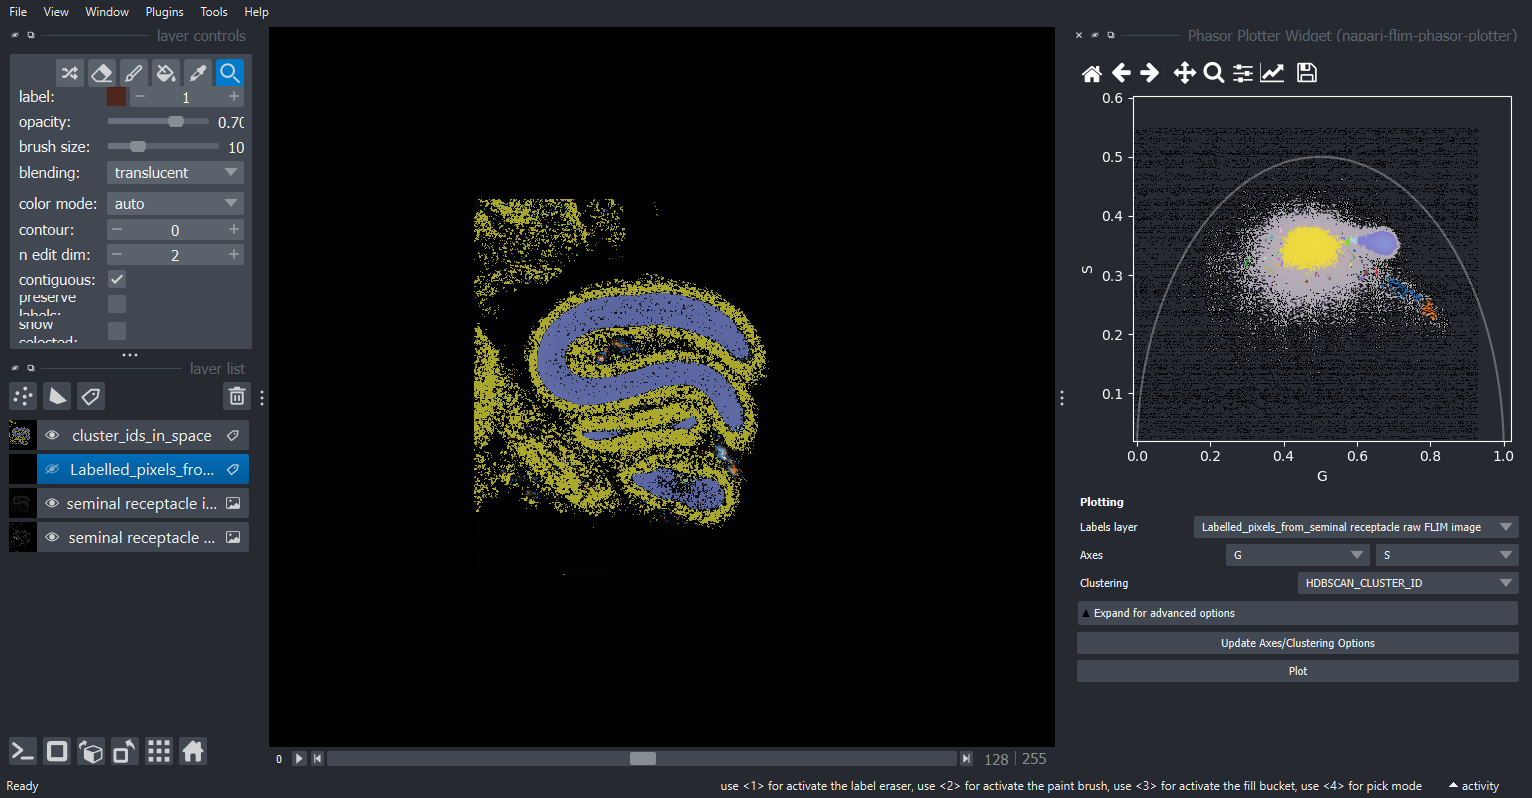

In [11]:
phasor_plot_widget.run(
    labels_layer.features,
    phasor_plot_widget.plot_x_axis.currentText(),
    phasor_plot_widget.plot_y_axis.currentText(),
    phasor_plot_widget.plot_cluster_id.currentText(),)
clusters_labels_layer = phasor_plot_widget.visualized_labels_layer
nbscreenshot(viewer)

Get n largest clusters

In [15]:
def get_n_laergest_cluster_labels(features_table: 'pd.DataFrame', n, clustering_id='HDBSCAN_CLUSTER_ID') -> List[int]:
    """Get the labels of the n largest clusters in a features table

    Parameters
    ----------
    features_table : pd.DataFrame
        table of features
    n : _type_
        number of clusters to return
    clustering_id : str, optional
        cluster id column name, by default 'HDBSCAN_CLUSTER_ID'

    Returns
    -------
    List[int]
        list of cluster labels
    """    
    unique_cluster_ids, counts = np.unique(features_table[clustering_id], return_counts=True)
    sorted_cluster_ids = unique_cluster_ids[np.argsort(counts)[::-1]] + 1 # compensata for -1 indexing
    sorted_cluster_ids = sorted_cluster_ids[sorted_cluster_ids > 0] # remove noise cluster
    
    return sorted_cluster_ids[:n]

In [18]:
labels = get_n_laergest_cluster_labels(features_table, 3)
labels

array([36, 20, 22], dtype=int64)

In [19]:
chosen_label = labels[1] # choose second largest cluster

Extract chosen label

In [20]:
@magicgui()
def manual_label_extract(labels_layer: "napari.layers.Labels", label_number: int = 1) -> "napari.layers.Labels":
    """Extracts single label from labels layer

    Parameters
    ----------
    labels_layer : napari.layers.Labels
        layer with labelled regions
    label_number : int, optional
        chosen label number to be extracted, by default 1

    Returns
    -------
    napari.layers.Labels
        layer with single label
    """    
    labels_data = np.squeeze(np.asarray(labels_layer.data))
    labels_data[labels_data != label_number] = 0
    label_color = labels_layer.color
    return napari.layers.Labels(labels_data, color=label_color)

# viewer.window.add_dock_widget(manual_label_extract, area='right')


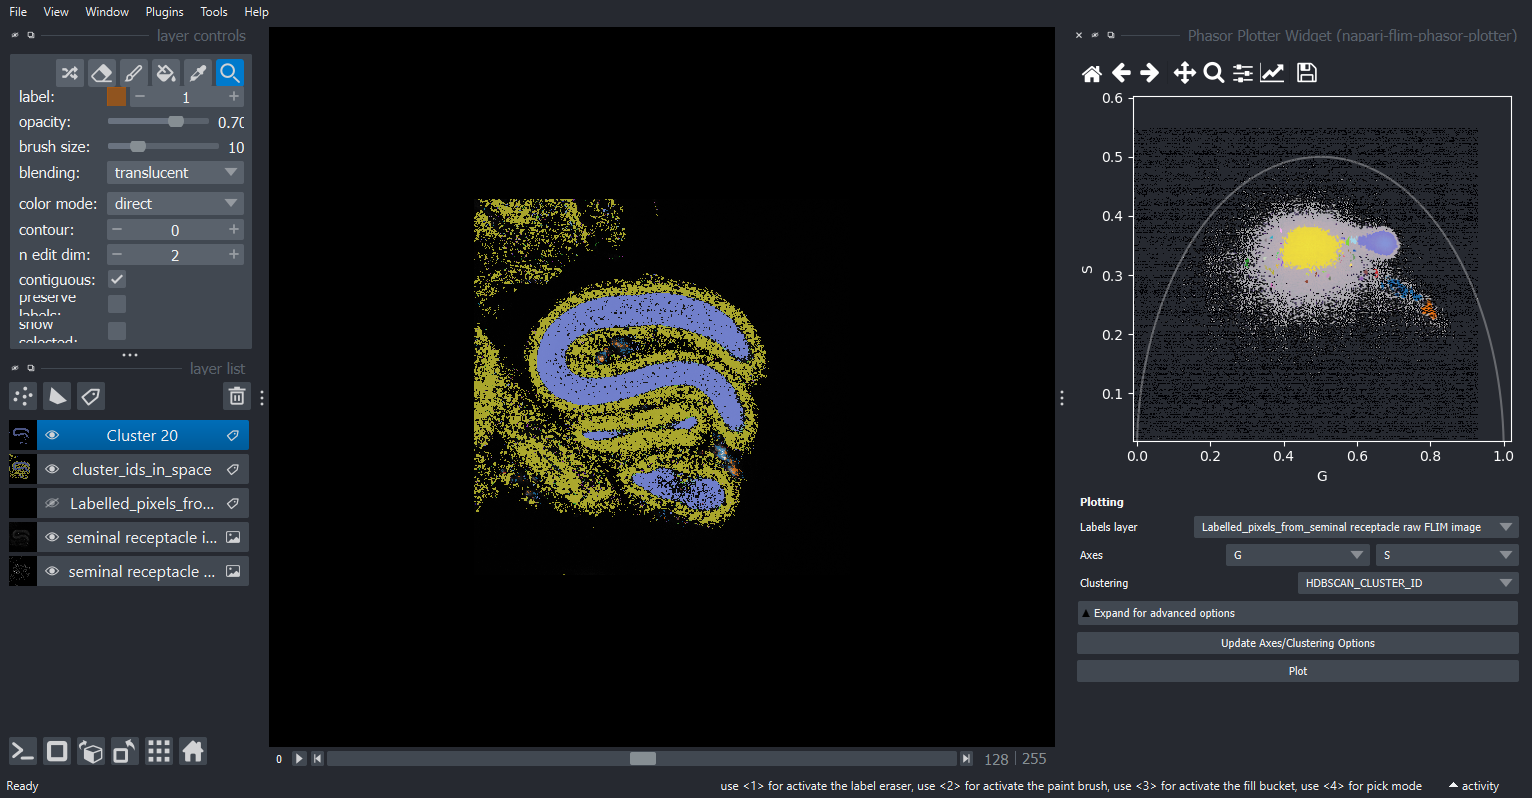

In [21]:
selected_labels_layer = manual_label_extract(clusters_labels_layer, chosen_label)
selected_labels_layer.name = f'Cluster {chosen_label}'
nbscreenshot(viewer)

Smooth chosen label (fill holes, connect close regions, remove small regions)

In [22]:
@magicgui()
def smooth_single_label(labels_layer: "napari.layers.Labels", area_threshold: int = 64, radius: int = 3) -> "napari.layers.Labels":
    """Smooths single label

    Parameters
    ----------
    labels_layer : napari.layers.Labels
        layer with labelled regions (with unique label number)
    area_threshold : int, optional
        threshold for area to fill, by default 64
    radius : int, optional
        radius of morphological operation, by default 3

    Returns
    -------
    napari.layers.Labels
        layer with smoothed labels
    """
    labels_data = np.squeeze(np.asarray(labels_layer.data))
    # Fill holes based on area threshold
    labels_data = morphology.area_closing(labels_data, area_threshold)
    # Connect nearby labels
    labels_data = morphology.isotropic_closing(labels_data, radius)
    # Remove small objects
    labels_data = morphology.isotropic_opening(labels_data, radius)
    # Restore label number
    labels_data = labels_data.astype(labels_layer.data.dtype)*labels_layer.data.max()
    label_color = labels_layer.color
    return napari.layers.Labels(labels_data, color=label_color)

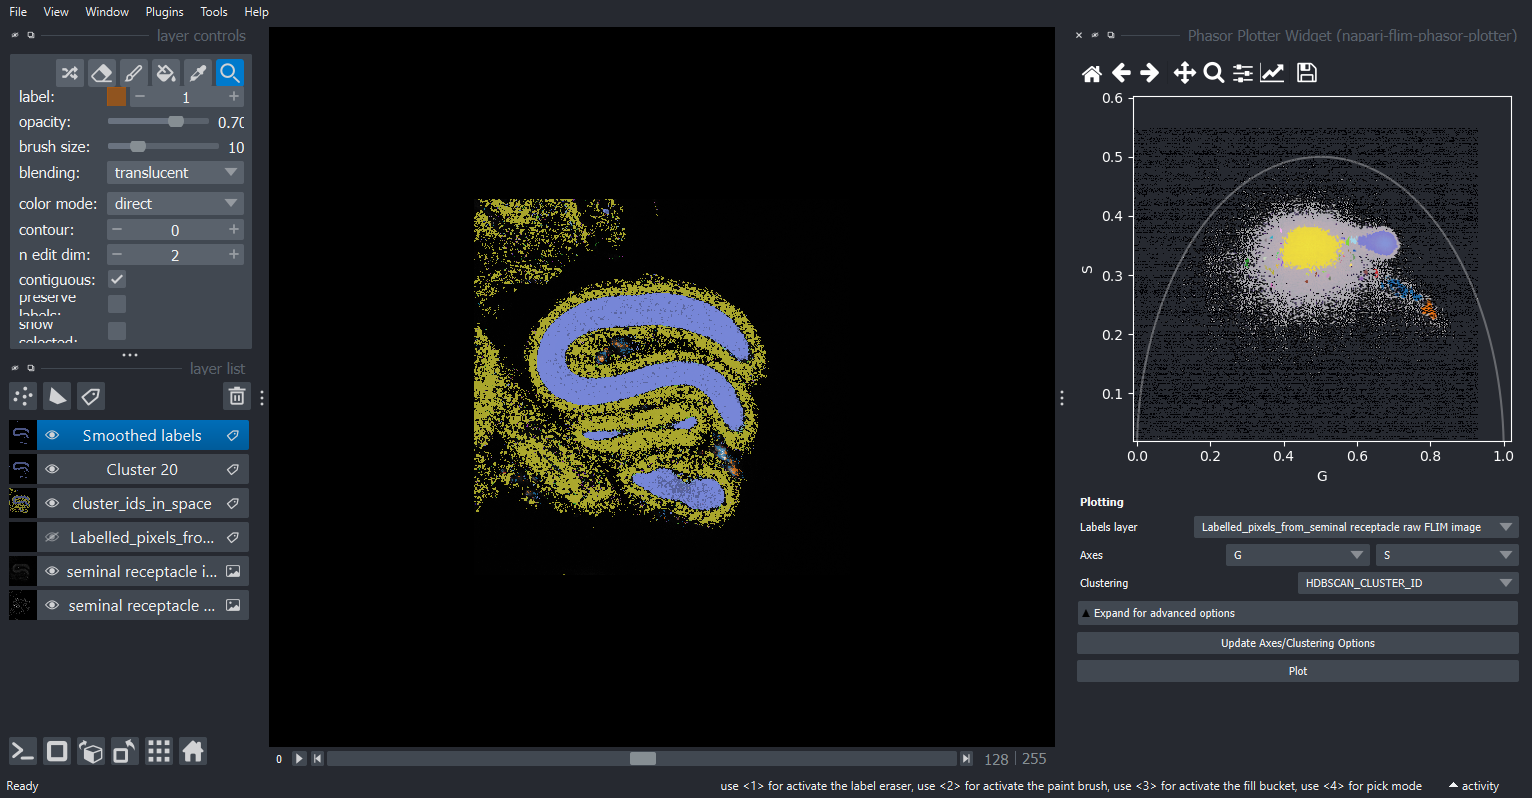

In [23]:
smoothed_labels_layer = smooth_single_label(selected_labels_layer)
smoothed_labels_layer.name = 'Smoothed labels'
nbscreenshot(viewer)

Connected Components Labeling

In [24]:
objects_labels = label(smoothed_labels_layer.data)
properties = regionprops_table(label_image = objects_labels, properties = ['label', 'area'])

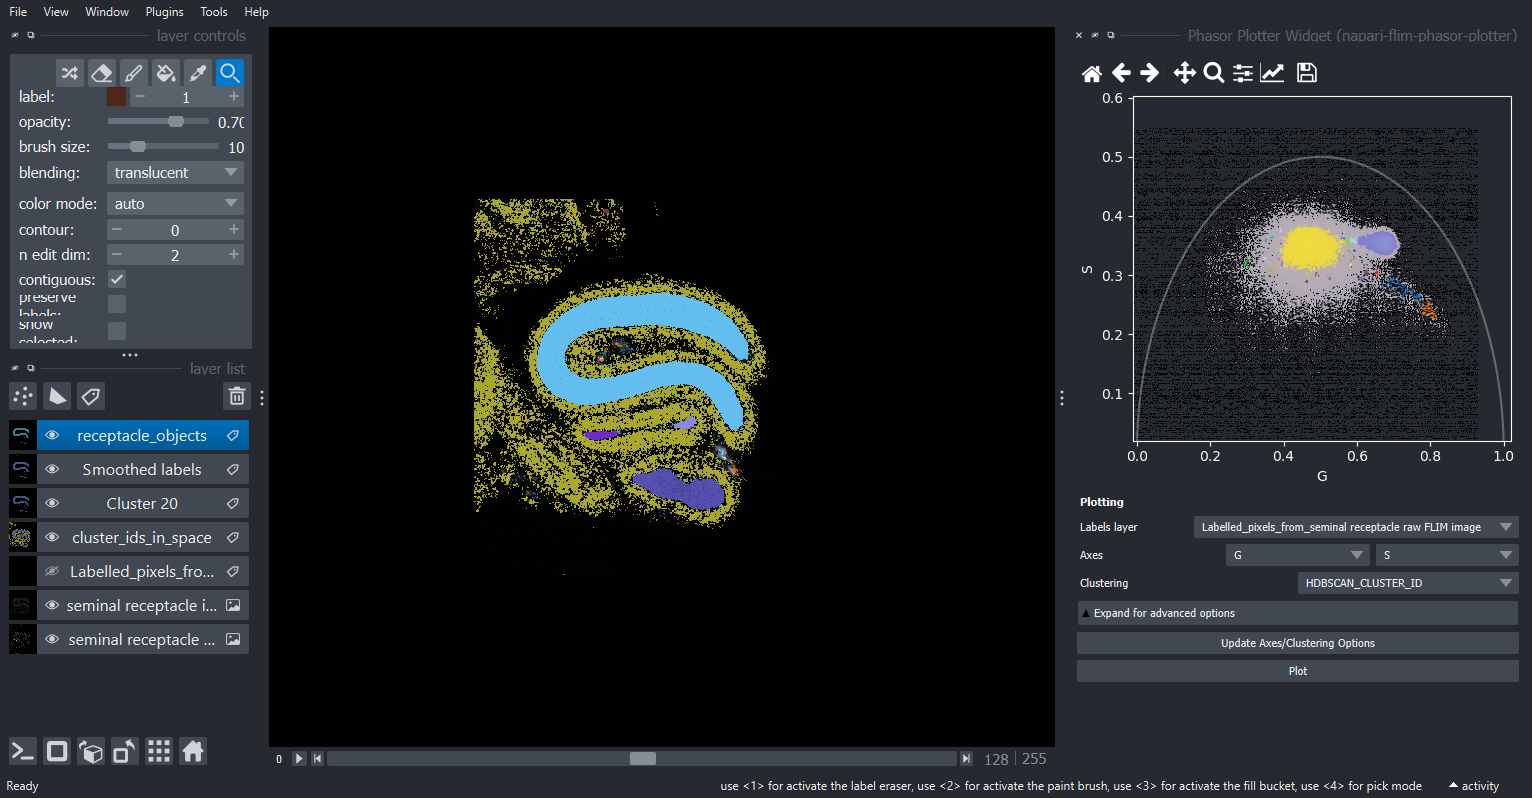

In [27]:
viewer.add_labels(objects_labels, features = properties, name = 'receptacle_objects')
nbscreenshot(viewer)

Display table
Tools > Measurement > Show Table (nsr) > Select 'receptacle objects' layer and RUN

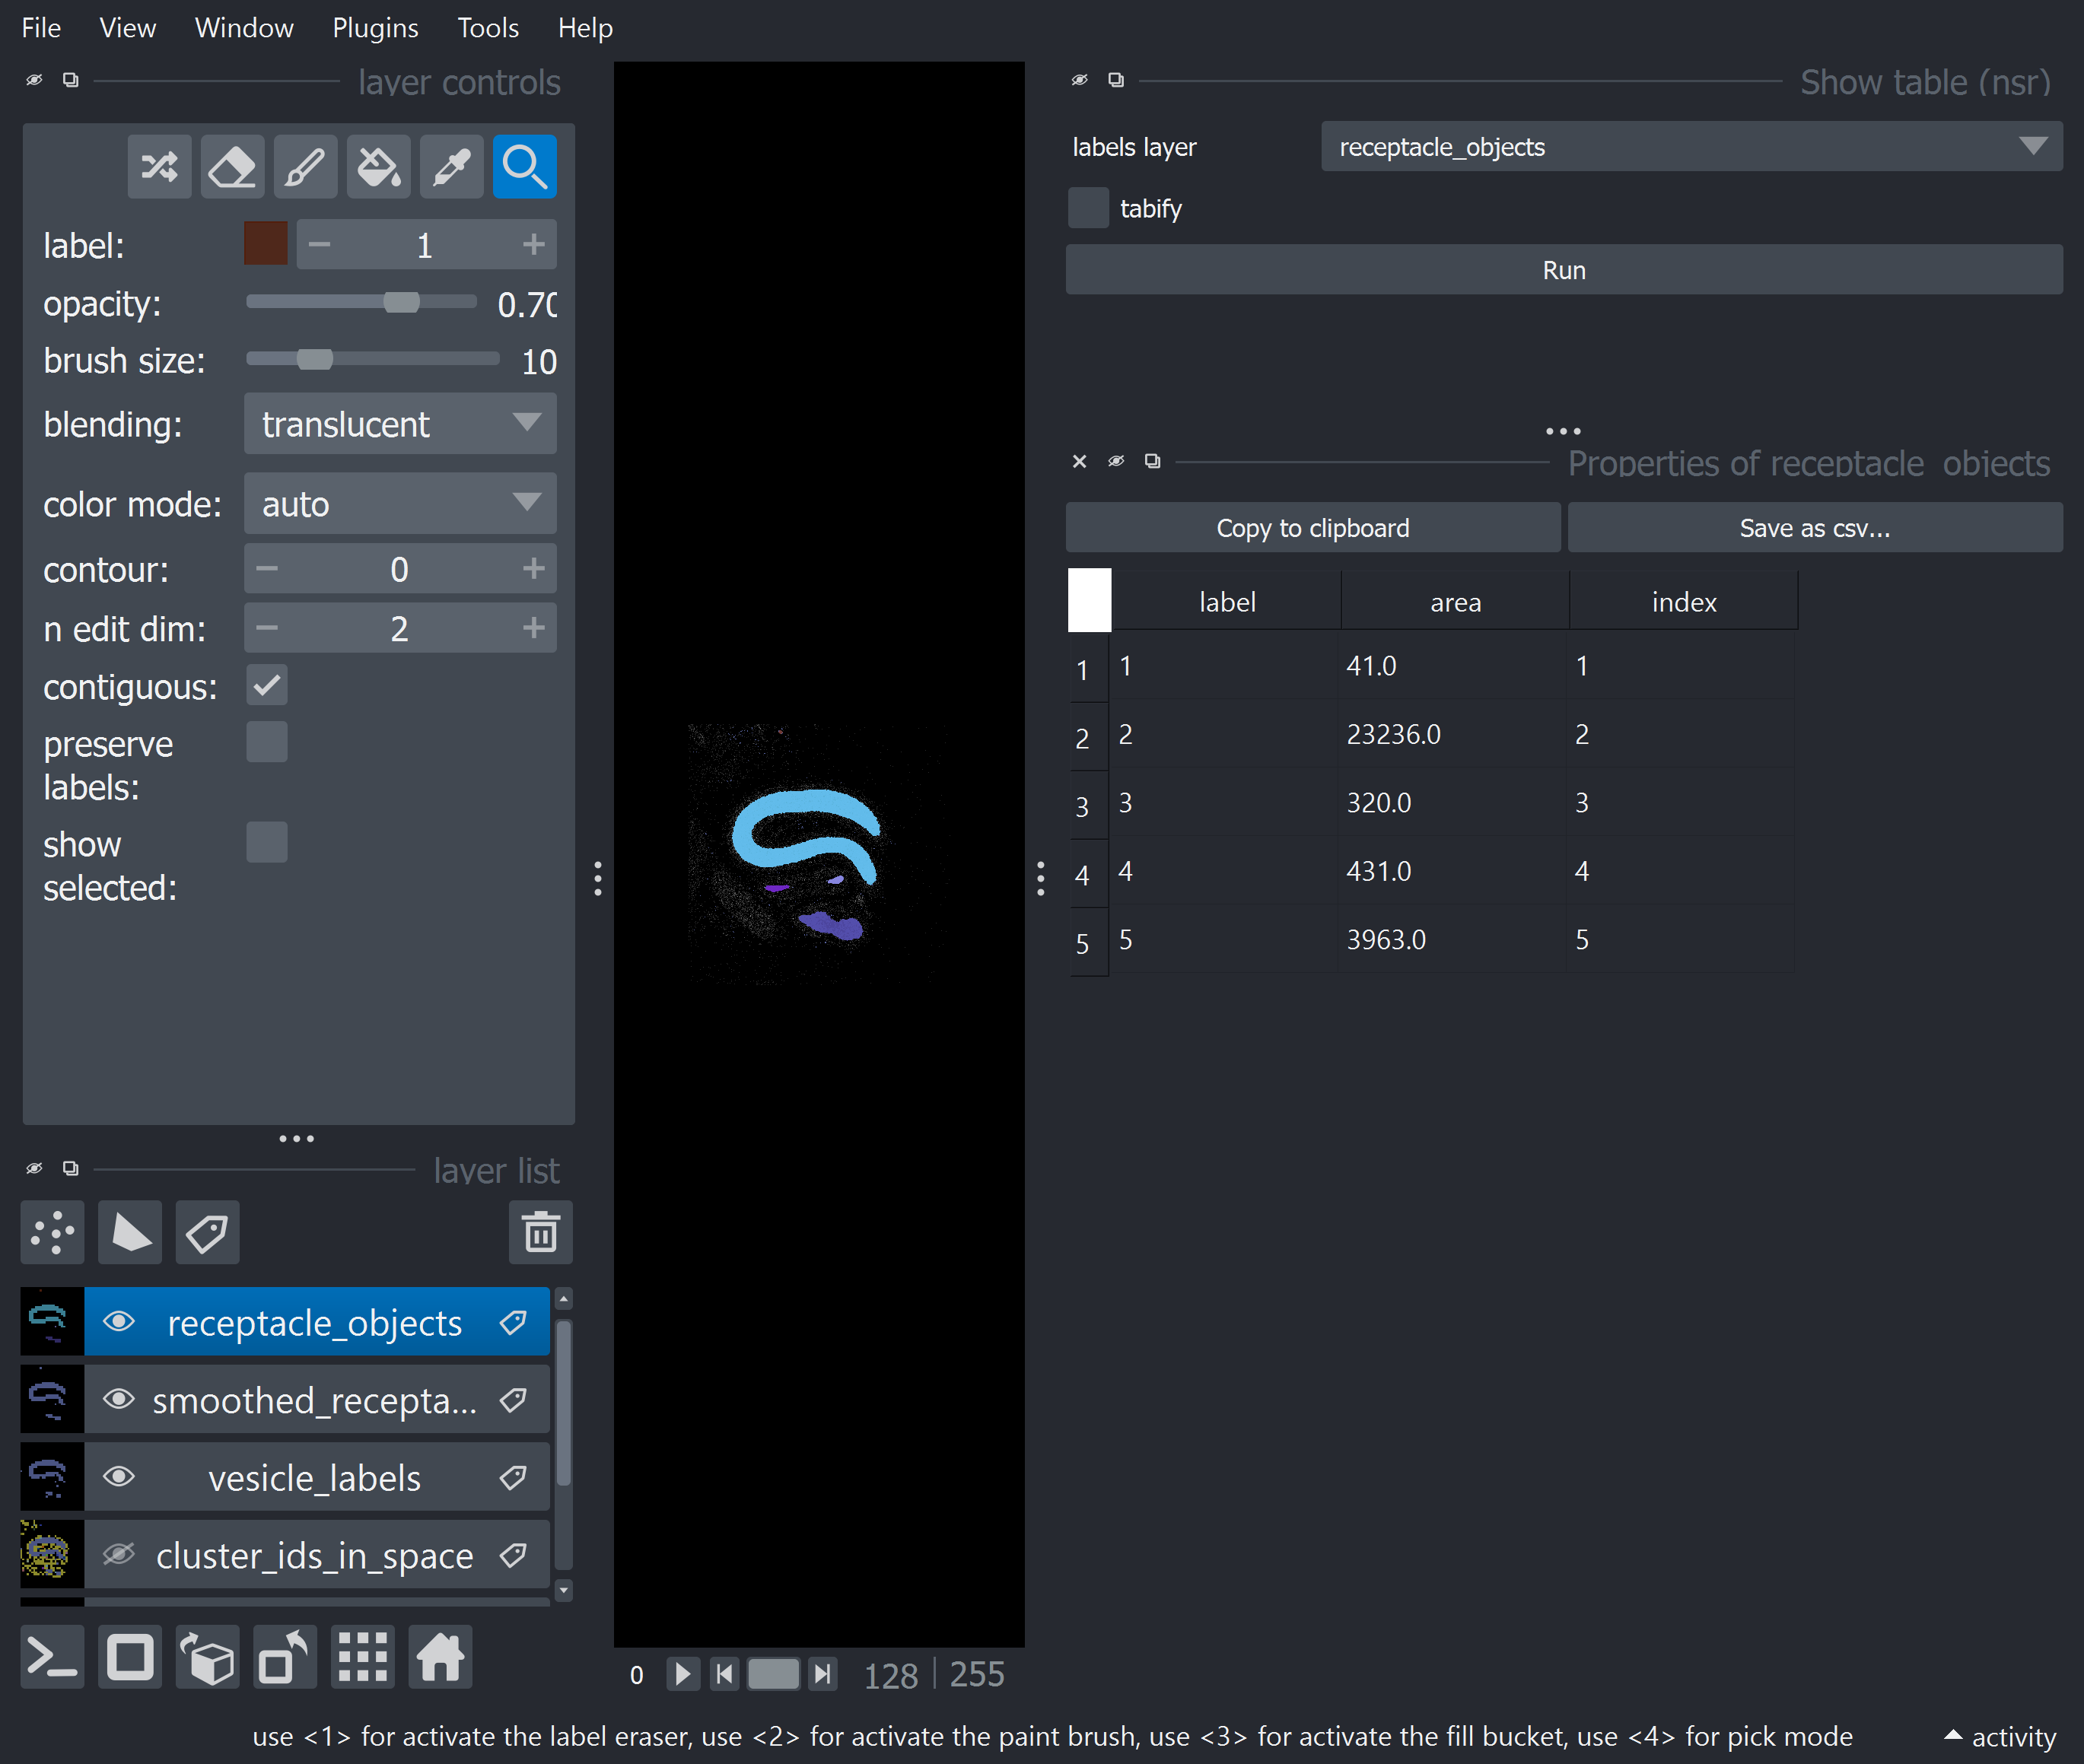

In [ ]:
nbscreenshot(viewer)